# Wine Quality Analysis

<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1133888244%2F0x0.jpg%3Ffit%3Dscale" width="600px" />

This notebook analyse a database of **red** and **white** variants of the Portuguese "Vinho Verde" wine based on wine **physicochemical test results** and quality scores that experts assign to each wine sample.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.utils.multiclass import unique_labels

import shap

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style='whitegrid')
set_config(display='diagram')


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
shap.initjs()

In [3]:
full_df = pd.read_csv('data/winequalityN.csv')

full_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Classification Objective

The most obvious classification objective for this training set is **multiclass wine quality classification**. 

The dataset is **higly imbalanced**. We have only 5 samples of exellent wines and 30 samples of the lowest quality wines. If we take into account test set split and cross-validation folds, we may have only a couple of examples during training. This means that there may be a problem of applying SMOTE and similar synthetical methods to balance datasets as they would require more samples to create clusters for samplings from.

Other possible objectives are:
- multiclass quality classification with only 3 classes: low, medium, high quality wines
- binary quality classification: good or bad quality wine
- binary wine type classification: red or white wine (which would also suffer from imbalance, but could be fixed by synthetic resampling)

In [4]:
full_df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

We will stick with **multiclass quality classification** and 3 classes: low, medium, high quality wines:

In [5]:
def impute_quality_group(quality):
    if quality <= 5:
        return 0 # low
    if quality > 5 and quality < 7:
        return 1 # average
    if quality >= 7:
        return 2 # high

full_df['quality_group'] = full_df['quality'].apply(impute_quality_group)

In [6]:
full_df['quality_group'].value_counts()

1    2836
0    2384
2    1277
Name: quality_group, dtype: int64

# Model

In [7]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='viridis', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [8]:
def score_classification_model(model, X_train, y_train):
    
    cv_scores = cross_validate(
        model, X_train, y_train, 
        scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
        cv=5,
        n_jobs=-1, verbose=0
    )

    cv_y_predicted = cross_val_predict(
        model, X_train, y_train,
        cv=5,
        n_jobs=-1
    )

    cv_f1_weighted, f1_weighted_std = cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std()
    cv_balanced_accuracy, balanced_accuracy_std = cv_scores['test_balanced_accuracy'].mean(), cv_scores['test_balanced_accuracy'].std()
    cv_accuracy, balanced_std = cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()

    model.fit(X_train, y_train)

    y_train_predicted = model.predict(X_train)

    train_f1_weighted = f1_score(y_train, y_train_predicted, average='weighted')
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_predicted)

    print('[Train] F1 Weighted: %.4f' % (train_f1_weighted))
    print('[Train] Balanced Accuracy: %.4f' % (train_balanced_accuracy))
    print('Train Set Report:')
    print(classification_report(y_train, y_train_predicted, digits=3))

    print('[CV] F1 Weighted: %.4f (%.4f)' % (cv_f1_weighted, f1_weighted_std))
    print('[CV] Balanced Accuracy: %.4f (%.4f)' % (cv_balanced_accuracy, balanced_accuracy_std))
    print('[CV] Accuracy: %.4f (%.4f)' % (cv_accuracy, balanced_std))
    print('CV Report:')
    print(classification_report(y_train, cv_y_predicted, digits=3))
    
    # display confusion matrixes

    _, (ax0, ax1) = plt.subplots(1, 2)

    ax0.set_title('Train Confusion Matrix')
    plot_confusion_matrix(
        model, X_train, y_train,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax0,
        colorbar=False,
    )

    ax1.set_title('CV Confusion Matrix')
    plot_confusion_matrix_by_predictions(
        y_train, cv_y_predicted,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax1,
        colorbar=False,
    )

    return y_train_predicted, cv_y_predicted

In [9]:
# sklearn's pipeline API is limited at this point and doesn't provide a way to get columns of transformed X array
# This snippet will cover our back 

def get_columns_from_transformer(column_transformer, input_colums):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)

    [_, _, reminder_columns] = column_transformer.transformers_[-1]

    for col_idx in reminder_columns:
        col_name.append(input_colums[col_idx])

    return col_name

# Feature Engineering

In [10]:
for feature in ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']:
    full_df[feature] = full_df.groupby(['type'])[feature].transform(lambda x: x.fillna(x.median()))

In [11]:
def impute_sweetness(residual_sugar):
    if residual_sugar < 1:
        return 0
    if residual_sugar >= 1 and residual_sugar < 9:
        return 1
    if residual_sugar >= 9 and residual_sugar < 18:
        return 2
    if residual_sugar >= 18 and residual_sugar < 50:
        return 3
    if residual_sugar >= 50 and residual_sugar < 120:
        return 4
    if residual_sugar >= 120:
        return 5

full_df['sweetness'] = full_df['residual sugar'].apply(impute_sweetness)

In [12]:
full_df['fixed_acidity_red_wine'] = (full_df['type'] == 'red') * full_df['fixed acidity']
full_df['fixed_acidity_white_wine'] = (full_df['type'] == 'white') * full_df['fixed acidity']

full_df['molecular_sulfur_dioxid'] = full_df['free sulfur dioxide'] / (1 + 10 ** (full_df['pH'] - 1.8))
full_df['free_total_so2_rate'] = full_df['free sulfur dioxide'] / full_df['total sulfur dioxide']
full_df['bound_sulfur_dioxid'] = full_df['total sulfur dioxide'] - full_df['free sulfur dioxide']
full_df['sugar_acidity_ratio'] = full_df['residual sugar'] / full_df['fixed acidity']

alcohol_labels = ['low', 'medium', 'high']
alcohol_bins = [0, 9.5, 11.5, 20]
full_df['alcohol_groups'] = pd.cut(full_df['alcohol'], bins=alcohol_bins, labels=alcohol_labels) 

pH_labels = ['high', 'mod high', 'medium', 'low']
pH_bins = [2.5, 3.2, 3.3, 3.4, 4.1]
full_df['pH_groups'] = pd.cut(full_df['pH'], bins=pH_bins, labels=pH_labels) 

Feature Engineering:
- `total sulfur dioxide` - doesn't improve models in a raw view
- `free_total_so2_rate` - brings 0 improvements
- `sweetness` - degrades performance of all models
- `alcohol_groups` - degrades performance of all models
- `pH_groups` - degrades performance of all models
- `sugar_acidity_ratio` improves score's std but degrades CV scores

In [68]:
model_features = [
    'type',
    'alcohol',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'pH',
    'residual sugar',
    'free sulfur dioxide',
    'chlorides',
    'density',
    'sulphates',
    'bound_sulfur_dioxid',
    'molecular_sulfur_dioxid',
    'sugar_acidity_ratio'
]

X = full_df[model_features]
y = full_df['quality_group']

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in stratified_splitter.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

# Data Processing

In [69]:
oneplus_transformer = FunctionTransformer(func=lambda x: 1 + x, inverse_func=lambda x: 1 - x)
boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)

numerical_transformer = Pipeline([
    ('positive_transforming', oneplus_transformer),
    ('boxcox_transforming', boxcox_transformer),
])

feature_transformer = ColumnTransformer([
        ('feature_transforming', numerical_transformer, [
            'fixed acidity', 'chlorides', 'citric acid', 'volatile acidity', 
            'sulphates', 'alcohol', 'residual sugar', 'free sulfur dioxide', 
            'sulphates', 'pH', 'sugar_acidity_ratio'
        ]),
        ('wine_type_onehot', OneHotEncoder(), ['type']),
    ],
    remainder='passthrough'
)

# LogisticRegression

In [70]:
logistic_regression = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    C=0.9,
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

logistic_regression_pipeline = Pipeline([
    ('feature_processing', feature_transformer),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_regression),
])

logistic_regression_pipeline

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function <lambda> at 0x141806dc0>,
                                                                                       inverse_func=<function <lambda> at 0x141806700>)),
                                                                  ('boxcox_transforming',
                                                                   PowerTransformer(method='box-cox',
                                                                                    standardize=False))]),
                                                  ['fixed a...
                                                   'citric acid',
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH',
                                                   'sugar_acidity_ratio']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(C=0.9, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, penalty='l1',
                                    random_state=42, solver='liblinear'))])

[Train] F1 Weighted: 0.5732
[Train] Balanced Accuracy: 0.5920
Train Set Report:
              precision    recall  f1-score   support

           0      0.630     0.726     0.674      1907
           1      0.580     0.443     0.502      2269
           2      0.489     0.607     0.542      1021

    accuracy                          0.579      5197
   macro avg      0.566     0.592     0.573      5197
weighted avg      0.580     0.579     0.573      5197

[CV] F1 Weighted: 0.5688 (0.0135)
[CV] Balanced Accuracy: 0.5866 (0.0099)
[CV] Accuracy: 0.5744 (0.0109)
CV Report:
              precision    recall  f1-score   support

           0      0.629     0.718     0.670      1907
           1      0.574     0.442     0.500      2269
           2      0.482     0.599     0.534      1021

    accuracy                          0.574      5197
   macro avg      0.561     0.587     0.568      5197
weighted avg      0.576     0.574     0.569      5197



(array([2, 2, 0, ..., 0, 2, 2]), array([2, 2, 0, ..., 0, 2, 2]))

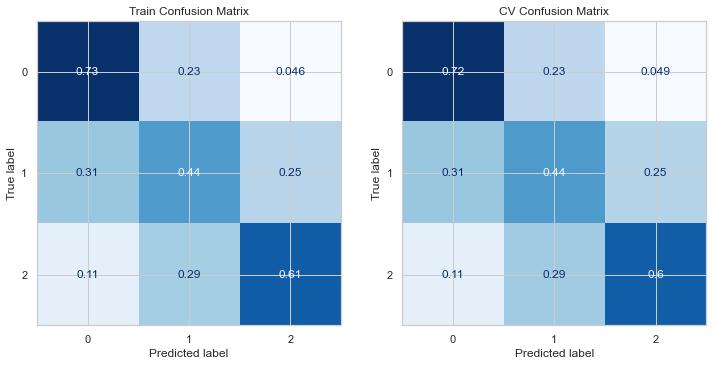

In [71]:
score_classification_model(logistic_regression_pipeline, X_train, y_train)

## Hyperparam Tuning

In [17]:
parameters = {
    'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
    'quality_classification__C': [1.0, 0.95, 0.9, 0.8], # 1.0
    'quality_classification__tol': [1e-4],
    'quality_classification__class_weight': ['balanced'],
    'quality_classification__solver': ['lbfgs', 'liblinear', 'sag', 'saga'], # lbfgs
    'quality_classification__max_iter': [500],
    'quality_classification__l1_ratio': [1.0, 0.0, 0.3, 0.4, 0.5],
}

param_searcher = GridSearchCV(
   estimator=logistic_regression_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# Polynomial Regression

In [72]:
logistic_classifier = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

polynomial_pipeline = Pipeline([
    ('feature_processing', feature_transformer),
    ('polynomial_features', PolynomialFeatures()),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_classifier),
])

polynomial_pipeline

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function <lambda> at 0x141806dc0>,
                                                                                       inverse_func=<function <lambda> at 0x141806700>)),
                                                                  ('boxcox_transforming',
                                                                   PowerTransformer(method='box-cox',
                                                                                    standardize=False))]),
                                                  ['fixed a...
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH',
                                                   'sugar_acidity_ratio']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('polynomial_features', PolynomialFeatures()),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='newton-cg'))])

[Train] F1 Weighted: 0.5900
[Train] Balanced Accuracy: 0.6313
Train Set Report:
              precision    recall  f1-score   support

           0      0.675     0.735     0.704      1907
           1      0.614     0.419     0.498      2269
           2      0.480     0.740     0.583      1021

    accuracy                          0.598      5197
   macro avg      0.590     0.631     0.595      5197
weighted avg      0.610     0.598     0.590      5197

[CV] F1 Weighted: 0.5723 (0.0111)
[CV] Balanced Accuracy: 0.6156 (0.0150)
[CV] Accuracy: 0.5815 (0.0129)
CV Report:
              precision    recall  f1-score   support

           0      0.655     0.725     0.688      1907
           1      0.595     0.396     0.475      2269
           2      0.470     0.726     0.571      1021

    accuracy                          0.581      5197
   macro avg      0.573     0.616     0.578      5197
weighted avg      0.592     0.581     0.572      5197



(array([2, 2, 1, ..., 2, 2, 2]), array([2, 2, 1, ..., 2, 2, 2]))

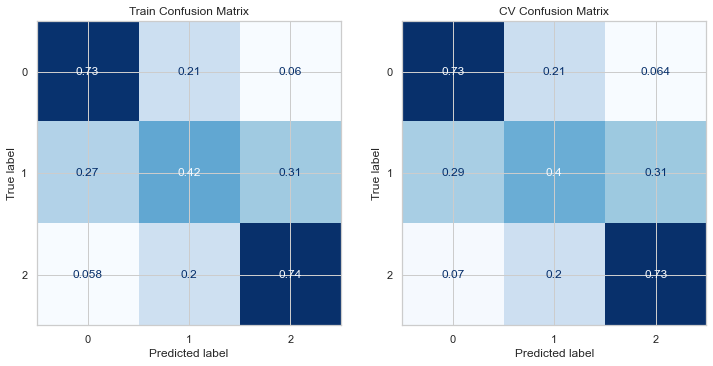

In [73]:
score_classification_model(polynomial_pipeline, X_train, y_train)

### Hyperparam Tuning

In [20]:
parameters = [
    {
        'quality_classification__solver': ['newton-cg'], # lbfgs, liblinear, 'lbfgs', 'sag', 'saga',
        'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
        'quality_classification__C': [1.0], # 1.0
        'quality_classification__l1_ratio': [1.0, 0.9],
        'quality_classification__max_iter': [100, 200],
        'quality_classification__class_weight': ['balanced'],
        'polynomial_features__degree': [2],
    },
]

param_searcher = GridSearchCV(
   estimator=polynomial_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

## RandomForest

In [74]:
from imblearn.pipeline import Pipeline as ImbalancePipeline

rf_classifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=179,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

rf_pipeline = ImbalancePipeline([
    ('feature_processing', feature_transformer),
    ('quality_classification', rf_classifier),
])

rf_pipeline

## F1 Weighted: 0.6949 (0.0167), Balanced Accuracy: 0.6948 (0.0211)
# criterion='entropy',
# n_estimators=179,
# min_samples_split=5,
# min_samples_leaf=4,
# max_features='sqrt',
# class_weight='balanced'

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function <lambda> at 0x141806dc0>,
                                                                                       inverse_func=<function <lambda> at 0x141806700>)),
                                                                  ('boxcox_transforming',
                                                                   PowerTransformer(method='box-cox',
                                                                                    standardize=False))]),
                                                  ['fixed a...
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH',
                                                   'sugar_acidity_ratio']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('quality_classification',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='sqrt', min_samples_leaf=4,
                                        min_samples_split=4, n_estimators=179,
                                        n_jobs=-1, random_state=42))])

[Train] F1 Weighted: 0.9544
[Train] Balanced Accuracy: 0.9603
Train Set Report:
              precision    recall  f1-score   support

           0      0.948     0.952     0.950      1907
           1      0.967     0.941     0.954      2269
           2      0.939     0.987     0.963      1021

    accuracy                          0.954      5197
   macro avg      0.952     0.960     0.956      5197
weighted avg      0.955     0.954     0.954      5197

[CV] F1 Weighted: 0.6949 (0.0167)
[CV] Balanced Accuracy: 0.6948 (0.0211)
[CV] Accuracy: 0.6954 (0.0171)
CV Report:
              precision    recall  f1-score   support

           0      0.739     0.755     0.747      1907
           1      0.671     0.655     0.663      2269
           2      0.664     0.675     0.670      1021

    accuracy                          0.695      5197
   macro avg      0.692     0.695     0.693      5197
weighted avg      0.695     0.695     0.695      5197



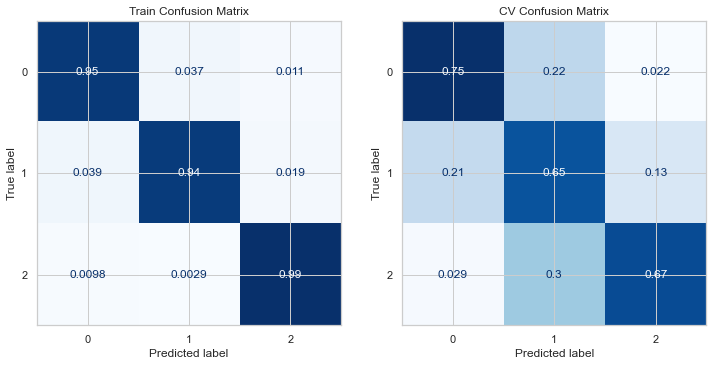

In [75]:
y_train_pred, y_cv_pred = score_classification_model(rf_pipeline, X_train, y_train)

### Hyperparam Tuning

In [23]:
parameters = {
    'quality_classification__n_estimators': [175, 180],
    'quality_classification__criterion': ['entropy', 'gini'], #
    'quality_classification__max_features': [None, 'sqrt', 'log2', 'auto'],
    'quality_classification__max_depth': [None], # 3, 4, 5
    'quality_classification__min_samples_split': [4], # 2
    'quality_classification__min_samples_leaf': [4], # 2
    'quality_classification__max_samples': [None], # 2
    'quality_classification__class_weight': ['balanced'],
}

param_searcher = GridSearchCV(
   estimator=rf_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# Model Inspection

In [76]:
X_train_features = get_columns_from_transformer(rf_pipeline.named_steps['feature_processing'], list(X_train.columns))

In [77]:
features_importance = sorted(zip(rf_pipeline.named_steps['quality_classification'].feature_importances_, X_train_features), reverse=True)

pd.DataFrame(features_importance, columns=['importance', 'feature'])

,importance,feature
0,0.169358,alcohol
1,0.098311,density
2,0.094423,volatile acidity
3,0.068760,bound_sulfur_dioxid
4,0.066850,chlorides
5,0.064416,citric acid
6,0.062228,sugar_acidity_ratio
7,0.060732,molecular_sulfur_dioxid
8,0.057921,free sulfur dioxide
9,0.054028,pH


In [26]:
#from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
#pdp_goals = pdp.pdp_isolate(model=rf_classifier, dataset=X_train_transformed, model_features=X_train_features, feature='alcohol')

# plot it
#pdp.pdp_plot(pdp_goals, 'alcohol')

In [79]:
y_test_predict = rf_pipeline.predict(X_test)

confused_middle_wines = [idx for idx, (y_true, y_pred) in enumerate(zip(y_test, y_test_predict)) if y_true == 2 and y_pred == 0]

confused_middle_wines

[28, 30, 72, 80, 405, 538, 1259]

In [80]:
X_test.iloc[1259], y_test.iloc[1259]

(type                          white
 alcohol                         9.9
 fixed acidity                   7.4
 volatile acidity               0.24
 citric acid                    0.26
 pH                             3.18
 residual sugar                  1.6
 free sulfur dioxide              53
 chlorides                     0.058
 density                      0.9936
 sulphates                       0.5
 bound_sulfur_dioxid              97
 molecular_sulfur_dioxid     2.12099
 sugar_acidity_ratio        0.216216
 Name: 2210, dtype: object,
 2)

In [81]:
X_test_transformed = pd.DataFrame(feature_transformer.transform(X_test), columns = X_train_features)

In [82]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf_classifier)

# Calculate Shap values
shap_values = explainer.shap_values(X_test_transformed, y_test)

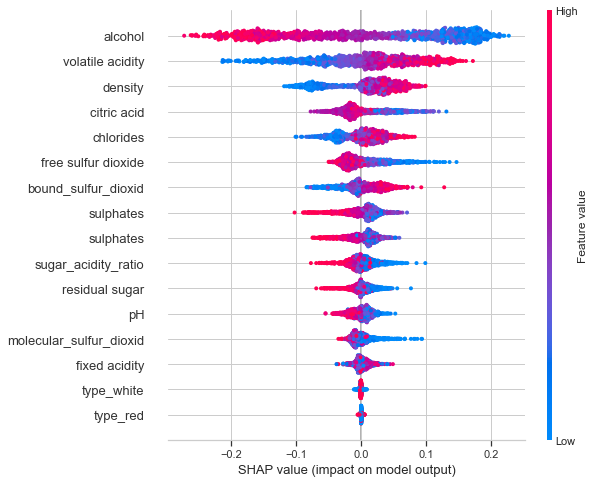

In [83]:
shap.summary_plot(shap_values[0], X_test_transformed)

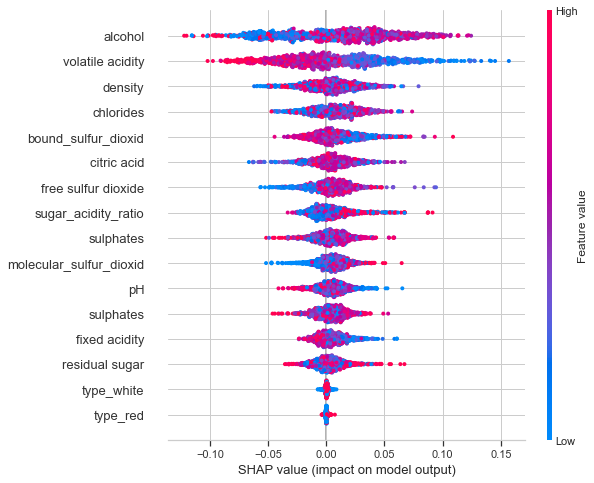

In [84]:
shap.summary_plot(shap_values[1], X_test_transformed)

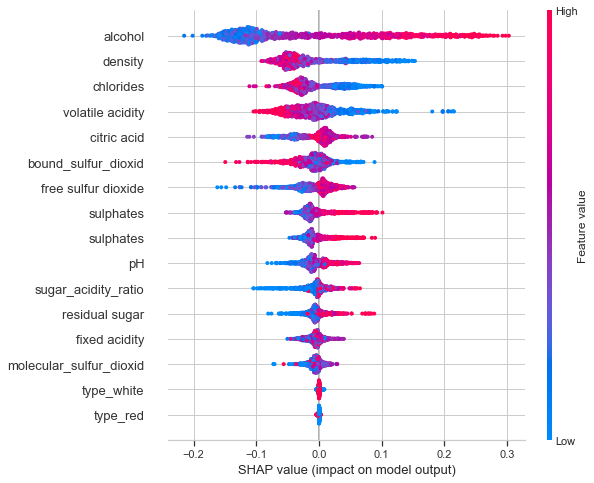

In [85]:
shap.summary_plot(shap_values[2], X_test_transformed)

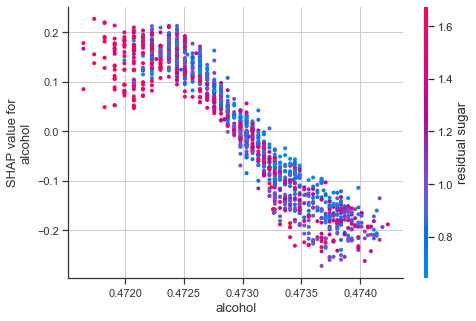

In [94]:
shap.dependence_plot('alcohol', shap_values[0], X_test_transformed, interaction_index='residual sugar')

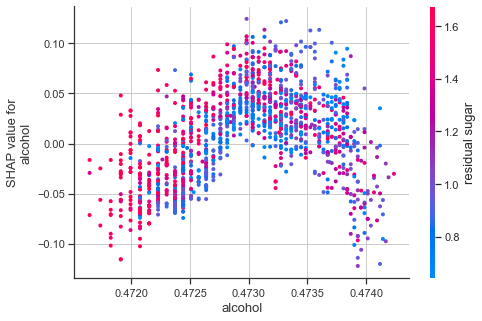

In [95]:
shap.dependence_plot('alcohol', shap_values[1], X_test_transformed, interaction_index='residual sugar')

Predicts 0 class instead of 2 class:
- Test 28 - alcohol
- Test 30 - volatile acidity + alcohol predicts + denisty 
- Test 72 - alcohol + free SO2
- Test 80 - sugar_acidity_ratio + chlorides + density
- Test 1259 - alcohol + citric acid + chlorides

In [66]:
shap.force_plot(explainer.expected_value[0], shap_values[0][30, :], X_test_transformed.iloc[30, :])

In [65]:
shap.force_plot(explainer.expected_value[2], shap_values[2][30, :], X_test_transformed.iloc[30, :])

# Generalization

In [33]:
def score_model_generalization(model, X_test, y_test):
    y_test_predicted = model.predict(X_test)

    test_f1_weighted = f1_score(y_test, y_test_predicted, average='weighted')
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)

    print('[Test] F1 Weighted: %.4f' % (test_f1_weighted))
    print('[Test] Balanced Accuracy: %.4f' % (test_balanced_accuracy))
    print('Test Set Report:')
    print(classification_report(y_test, y_test_predicted, digits=3))

    plot_confusion_matrix_by_predictions(
        y_test, y_test_predicted,
        cmap=plt.cm.Greens,
        normalize='true',
        colorbar=False,
    )

## Logistic Regression

[Test] F1 Weighted: 0.5472
[Test] Balanced Accuracy: 0.5647
Test Set Report:
              precision    recall  f1-score   support

           0      0.618     0.681     0.648       477
           1      0.535     0.427     0.475       567
           2      0.466     0.586     0.519       256

    accuracy                          0.552      1300
   macro avg      0.540     0.565     0.547      1300
weighted avg      0.552     0.552     0.547      1300



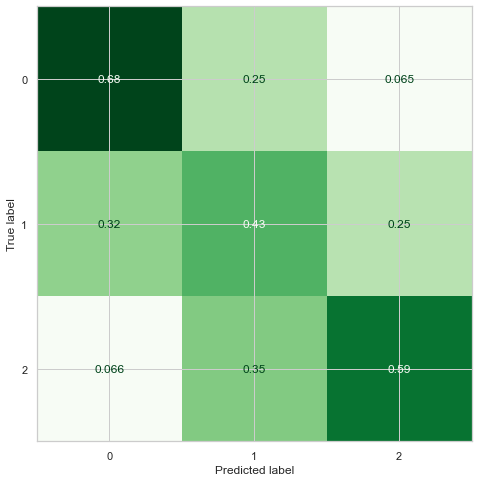

In [57]:
score_model_generalization(logistic_regression_pipeline, X_test, y_test)

## Polynomial Regression

[Test] F1 Weighted: 0.5388
[Test] Balanced Accuracy: 0.5858
Test Set Report:
              precision    recall  f1-score   support

           0      0.632     0.679     0.655       477
           1      0.548     0.363     0.437       567
           2      0.445     0.715     0.549       256

    accuracy                          0.548      1300
   macro avg      0.542     0.586     0.547      1300
weighted avg      0.558     0.548     0.539      1300



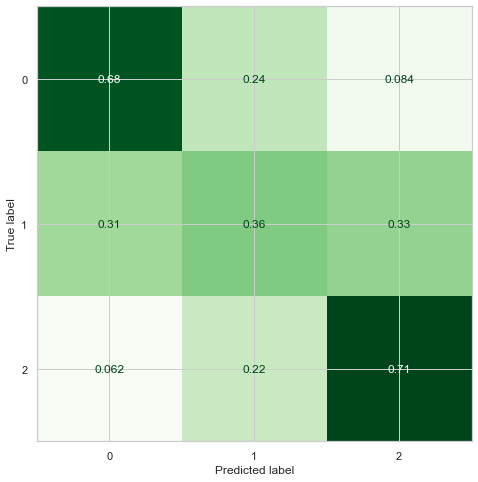

In [58]:
score_model_generalization(polynomial_pipeline, X_test, y_test)

## Random Forest

[Test] F1 Weighted: 0.7018
[Test] Balanced Accuracy: 0.7052
Test Set Report:
              precision    recall  f1-score   support

           0      0.759     0.738     0.748       477
           1      0.676     0.667     0.671       567
           2      0.657     0.711     0.683       256

    accuracy                          0.702      1300
   macro avg      0.697     0.705     0.701      1300
weighted avg      0.703     0.702     0.702      1300



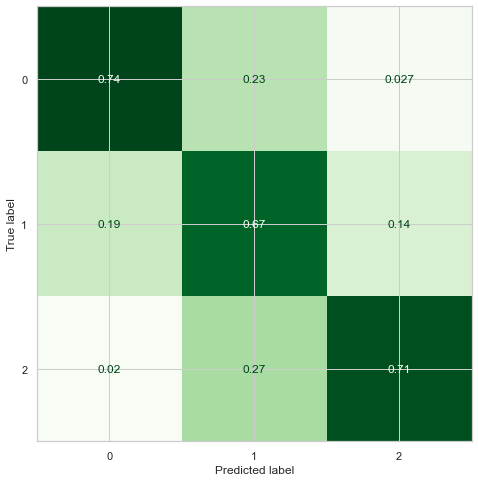

In [67]:
score_model_generalization(rf_pipeline, X_test, y_test)